# Portfolio Optimization (Hierarchical Risk Parity)

## Authors
- Sebastian Kreuz
- Maximilian Ehmann

In this example, we will implement hierarchical risk parity based on clustering
methods and compare it against other portfolio allocation methods. The code is based on the case study of Hariom Tatsath and Sahil Puri which can be found in https://github.com/tatsath/fin-ml/tree/master/Chapter%208%20-%20Unsup.%20Learning%20-%20Clustering/Case%20Study3%20-%20Hierarchial%20Risk%20Parity and is itself based on the paper _“Building Diversified Portfolios that Outperform Out-ofSample” (2016) by Marcos Lopez de Prado._

# 1. Problem Definition

Our goal in this case study is to maximize risk-adjusted returns using a clustering
reduction-based algorithm on a dataset of stocks to allocate capital into different asset
classes. 

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

Check if the packages needed are present, if not install them.

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date

#Import Model Packages 
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

#Package for optimization of mean variance optimization
import cvxopt as opt
from cvxopt import blas, solvers


## 2.1. Loading the classes and functions from this project

In [3]:
import sys
sys.path.append('../')
from src.finance_ml.data_preparation import DataLoader
from src.finance_ml.porfolio_optimization import PortfolioOptimization, show_dendogram, show_pie_charts, show_result_plot

<a id='1.2'></a>
## 2.2. Loading the Data

In [4]:
# load dataset
dataloader = DataLoader(time_index_col='DATE', keep_cols=['OPEN'])

fname_AAPL = '../data/equities/AAPL_2020-04-07_2022-04-06.parquet'
fname_FB =  '../data/equities/FB_2020-04-07_2022-04-06.parquet'
fname_TSLA = '../data/equities/TSLA_2020-04-07_2022-04-06.parquet'
fname_GLD = '../data/commodities/GLD_2020-04-07_2022-04-06.parquet'
fname_PDBC = '../data/commodities/PDBC_2020-04-07_2022-04-06.parquet'
fname_SLV = '../data/commodities/SLV_2020-04-07_2022-04-06.parquet'
fname_BTCUSD = '../data/cryptos/BTCUSD_2020-04-07_2022-04-06.parquet'
fname_ETHUSD = '../data/cryptos/ETHUSD_2020-04-07_2022-04-06.parquet'
fname_DOGEUSD = '../data/cryptos/DOGEUSD_2020-04-07_2022-04-06.parquet'
fname_RUBEUR = '../data/FX/RUBEUR_2020-04-07_2022-04-06.parquet'
fname_USDEUR = '../data/FX/USDEUR_2020-04-07_2022-04-06.parquet'
fname_USDBRL = '../data/FX/USDBRL_2020-04-07_2022-04-06.parquet'
#fname_IGIB = '../data/fixed_income/IGIB_2020-04-07_2022-04-06.parquet'
#fname_USIG =  '../data/fixed_income/USIG_2020-04-07_2022-04-06.parquet'
#fname_VCIT = '../data/fixed_income/VCIT_2020-04-07_2022-04-06.parquet'
#fname_KBWY = '../data/real_estate/KBWY_2020-04-07_2022-04-06.parquet'
#fname_SRET = '../data/real_estate/SRET_2020-04-07_2022-04-06.parquet'
#fnam_VNQI = '../data/real_estate/VNQI_2020-04-07_2022-04-06.parquet'


N = 20000
assets = {'AAPL': fname_AAPL, 'FB': fname_FB, 'TSLA': fname_TSLA, 'GLD': fname_GLD, 'PDBC': fname_PDBC, 'SLV': fname_SLV, 'BTCUSD': fname_BTCUSD, 
          'ETHUSD': fname_ETHUSD, 'DOGEUSD': fname_DOGEUSD, 'RUBEUR': fname_RUBEUR, 'USDEUR': fname_USDEUR, 'USDBRL': fname_USDBRL}
          #'IGIB': fname_IGIB, 'USIG': fname_USIG, 'VCIT': fname_VCIT, 'KBWY': fname_KBWY, 'SRET': fname_SRET, 'VNQI': fnam_VNQI}

dataset = dataloader.load_dataset(assets).iloc[:N]
dataset.columns = dataset.columns.str.rstrip('_OPEN')

if type(dataset) != pd.core.frame.DataFrame:
    raise Exception(f"Error in hierarch_risk_parity: Expected type pandas dataframe, but got {type(dataset)}")

dataset.interpolate(method='linear', inplace=True)  # For ticks where values in a row are N.A., the value is determined by linear interpolation of the last and next valid values
dataset = dataset.dropna()  # The first and last rows might still be N.A (no two values for interpolation available), these are dropped

<a id='2'></a>
# 3. Data Analysis

In [5]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# shape
dataset.shape

(19590, 12)

In [7]:
# peek at data
set_option('display.width', 100)
dataset.head(5)

,AAPL,FB,TSLA,GLD,PDBC,SLV,BTCUSD,ETHUSD,DOGEUSD,RUBEUR,USDEUR,USDBRL
DATE,,,,,,,,,,,,
2020-04-07 19:07:00,65.2986,168.490,109.2410,155.040,12.040,13.9200,7329.42,170.800,0.001990,0.01217,0.91768,5.221237
2020-04-07 19:08:00,65.2050,168.260,109.2200,154.990,12.040,13.9133,7341.62,170.650,0.001991,0.01217,0.91771,5.221250
2020-04-07 19:09:00,65.2725,168.430,109.5000,154.950,12.045,13.9100,7329.78,170.440,0.001987,0.01217,0.91740,5.221400
2020-04-07 19:10:00,65.5025,168.935,109.5515,154.970,12.045,13.9300,7332.84,170.681,0.001991,0.01217,0.91750,5.221380
2020-04-07 19:11:00,65.6175,169.340,109.7884,154.995,12.045,13.9225,7351.40,170.730,0.001993,0.01217,0.91769,5.221360


<a id='3'></a>
## 4. Data Preparation

We will train the data followed by testing. Let us prepare the dataset for training and testing, by separating 20% of the dataset for testing followed by generating the return series.

In [8]:
data = dataset.copy('deep')
row_count = len(data)
training_row_count = int(row_count *0.8)

In [9]:
data_train = data.head(training_row_count)
data_test = data.tail(row_count - training_row_count)

Initiate the portfolio optimization class

In [10]:
portfolio_optimizer = PortfolioOptimization(data_train=data_train, data_test=data_test)

In [11]:
# When implemented the following code line can call the monte carlo analyzation
# returns = portfolio_optimizer.hrp_MC()

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Building Hierarchy Graph/ Dendogram

The first step is to look for clusters of correlations using the agglomerate hierarchical clustering technique. The portfolio_optimization module
has a dendrogram method which takes a linkage as argument.

Linkage does the actual clustering in one line of code, and returns a list of the clusters joined in the format: Z=[stock_1, stock_2, distance, sample_count]

In [12]:
#Calulate linkage
link = portfolio_optimizer.calc_linkage('ward')

Computation of linkages is followed by
the visualization of the clusters through a dendrogram, which displays a cluster tree.
The leaves are the individual stocks and the root is the final single cluster. The “distance” between each cluster is shown on the y-axis, and thus the longer the branches
are, the less correlated two clusters are.

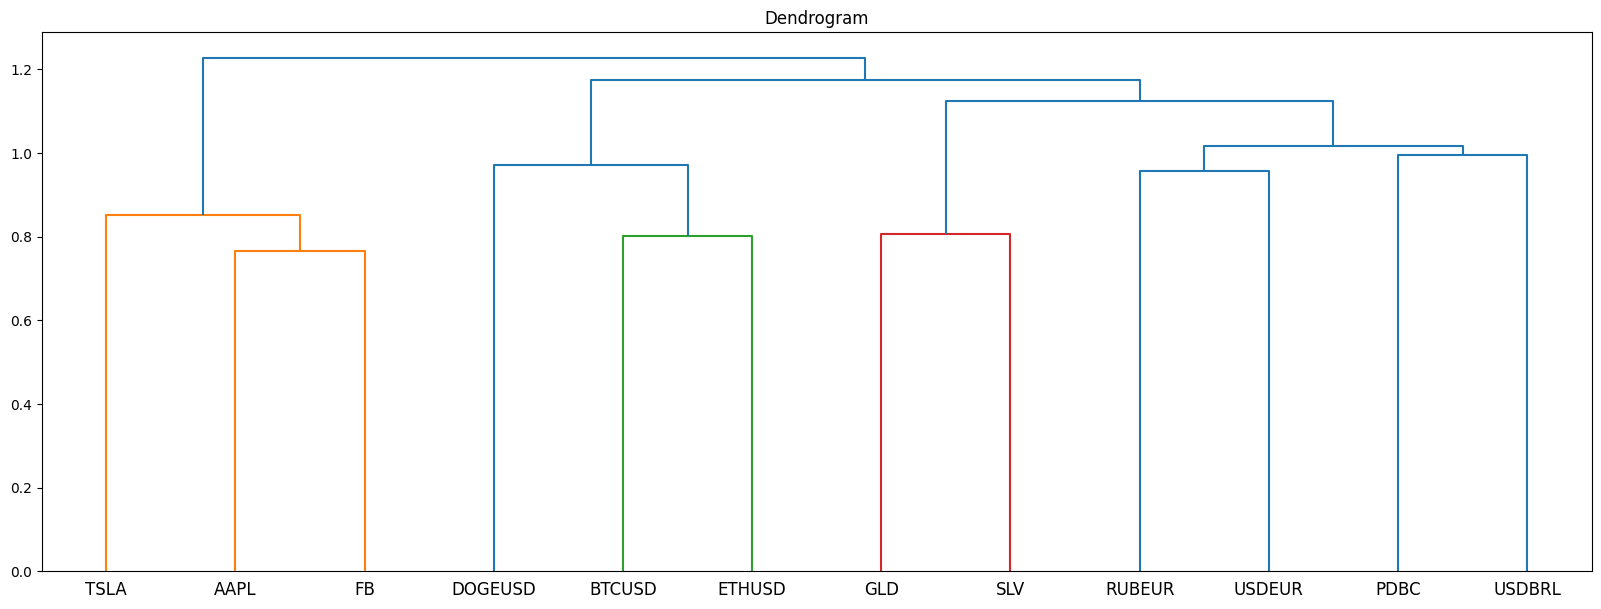

In [13]:
#Plot Dendogram
show_dendogram(link,labels = data_train.columns)

<a id='4.2'></a>
## 5.2 Steps for Hierarchial Risk Parity

#### Quasi-diagonalization and getting the weights for Hierarchial Risk Parity


A 'quasi-diagonalization' is a process usually known as matrix seriation and which can be performed using hierarchical clustering.
This process reorganizes the covariance matrix so similar investments will be placed together. This matrix diagonalization allow us to distribute weights optimally following an inverse-variance allocation.

In [14]:
def get_quasi_diag(self) -> list:
    # ... Implementation in python module
    pass

#### Recursive bisection

 This step distributes the allocation through recursive bisection based on cluster covariance.

In [15]:
def get_rec_bipart(self, sort_ix) -> pd.Series:
   # ... Implementation in python module
    pass

#### Comparison against other asset allocation methods:.

The following allocation models are implemented in the PorfolioOptimization class for comparison:
    
##### 1. CLA - Markowitz’s Minimum-Variance Portfolio

In [16]:
cla = portfolio_optimizer.get_CLA()
cla

AAPL       0.084498
FB         0.084282
TSLA       0.072760
GLD        0.092373
PDBC       0.092078
SLV        0.089303
BTCUSD     0.066182
ETHUSD     0.059899
DOGEUSD    0.076879
RUBEUR     0.092193
USDEUR     0.094947
USDBRL     0.094605
dtype: float64

##### 2. IVP - Inverse Variance Portfolio

In [17]:
ivp = portfolio_optimizer.get_IVP()
ivp

AAPL       0.031943
FB         0.026543
TSLA       0.007343
GLD        0.110222
PDBC       0.082003
SLV        0.045558
BTCUSD     0.004820
ETHUSD     0.002965
DOGEUSD    0.008629
RUBEUR     0.045901
USDEUR     0.428871
USDBRL     0.205201
dtype: float64

##### 3. HRP - Hierarchial Risk Parity

In [18]:
hrp = portfolio_optimizer.get_HRP()
hrp

AAPL       0.016449
BTCUSD     0.005185
DOGEUSD    0.009388
ETHUSD     0.002326
FB         0.013668
GLD        0.091234
PDBC       0.088328
RUBEUR     0.049942
SLV        0.033150
TSLA       0.005761
USDBRL     0.223184
USDEUR     0.461384
dtype: float64

##### Getting the portfolio weights for all three types of asset allocation

In [19]:
portfolios = portfolio_optimizer.get_all_portfolios()
portfolios

,CLA,IVP,HRP
AAPL,0.084498,0.031943,0.016449
BTCUSD,0.066182,0.004820,0.005185
DOGEUSD,0.076879,0.008629,0.009388
ETHUSD,0.059899,0.002965,0.002326
FB,0.084282,0.026543,0.013668
GLD,0.092373,0.110222,0.091234
PDBC,0.092078,0.082003,0.088328
RUBEUR,0.092193,0.045901,0.049942
SLV,0.089303,0.045558,0.033150
TSLA,0.072760,0.007343,0.005761


##### Plotted in pie charts

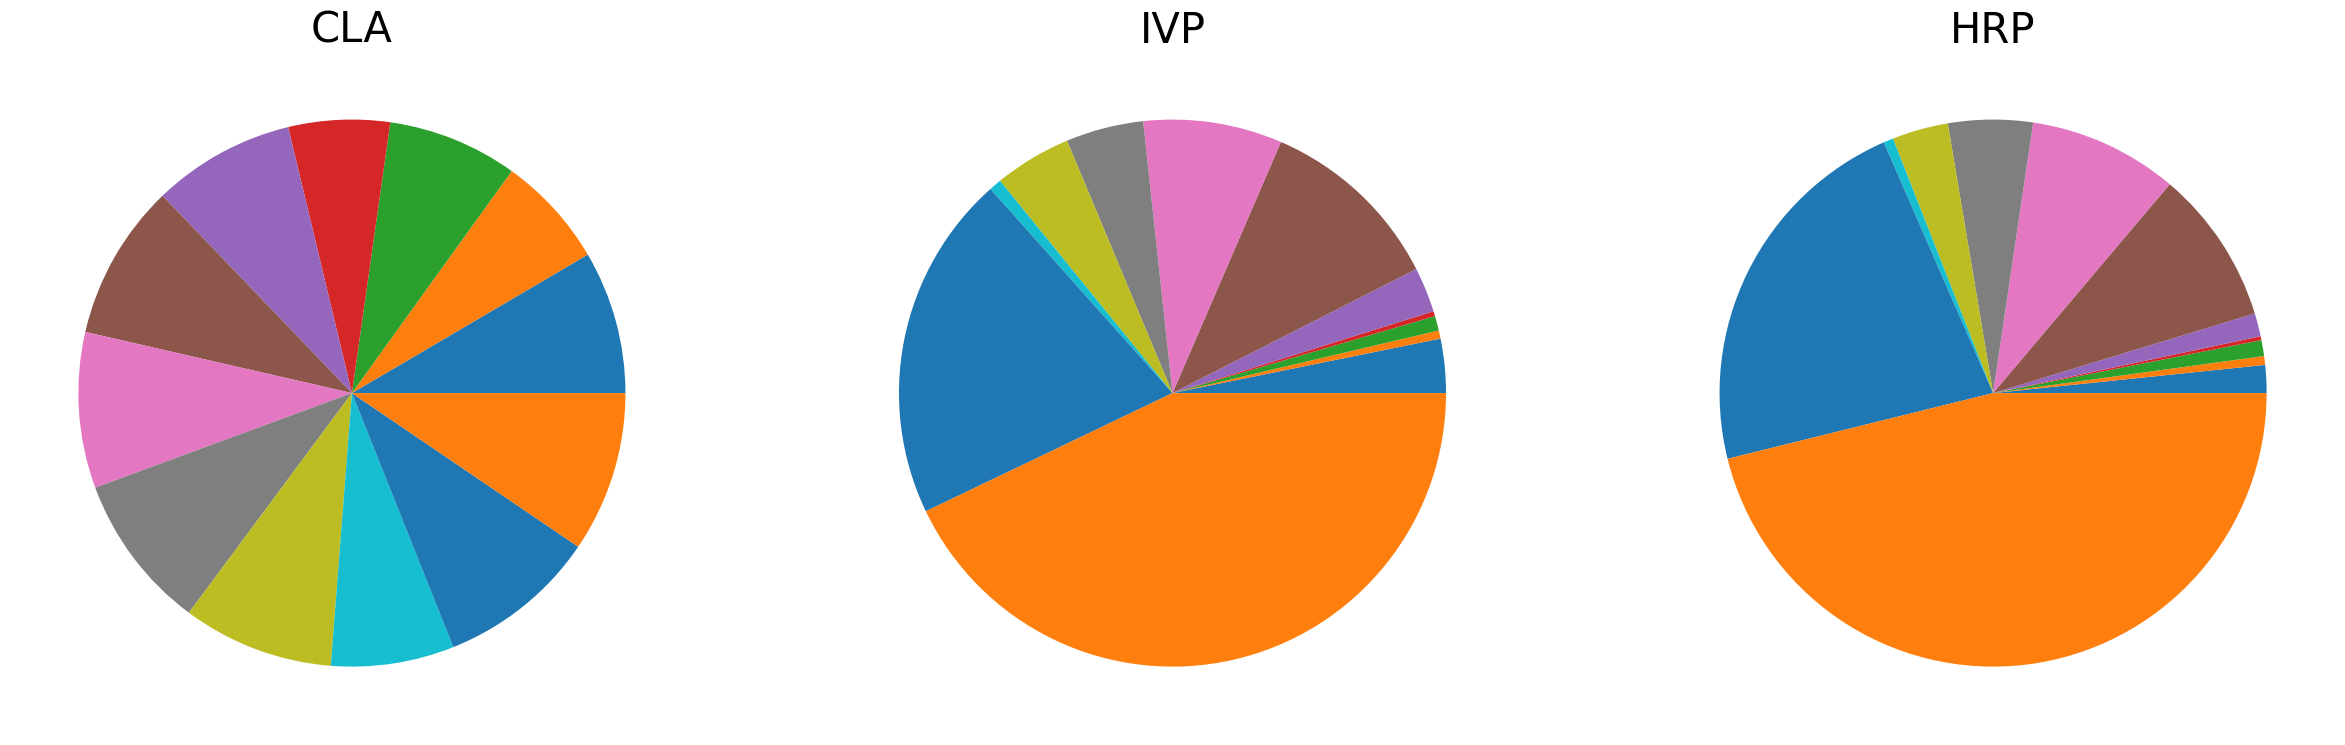

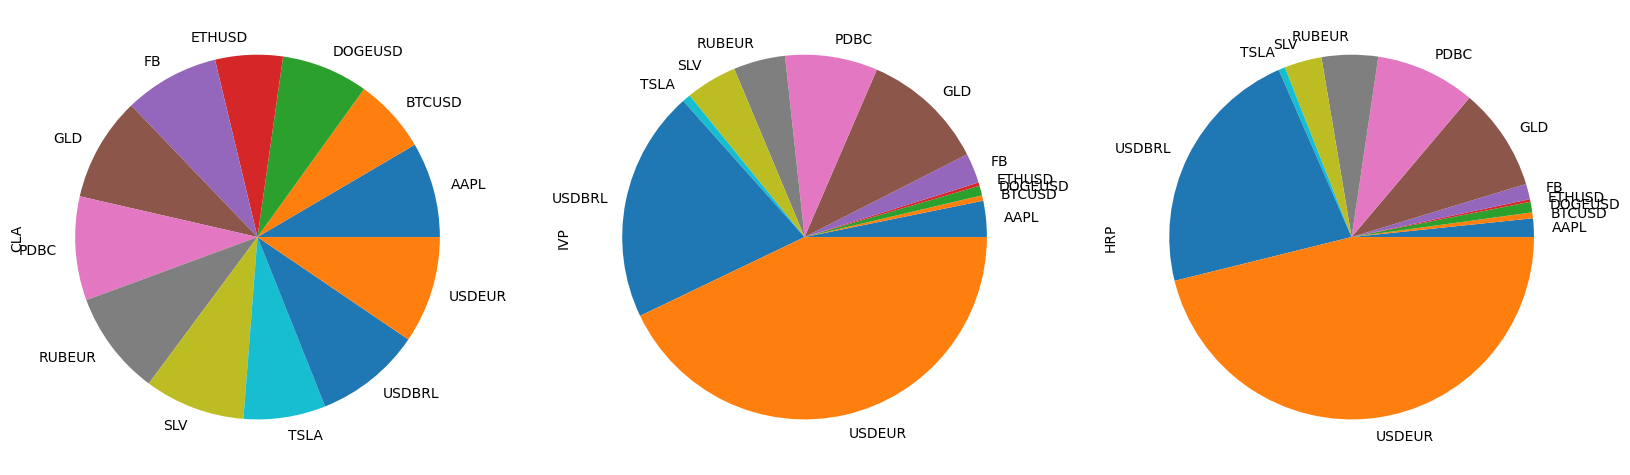

In [20]:
show_pie_charts(portfolios)

The first pie chart shown the asset allocation of CLA, followed by IVP and HRP. What we expected to see was much more diversification in HRP as compared to CLA and similar results between HRP and IVP. However, we can see a broader diversification in CLA and both HRP and IVP relying nearly 3/4 of the porfolios on the USD currency exchanges to EUR and BRL. We explain this to ourselves by the given data relying heavily on the USD and also a not big enough training sample of only N = 20000.

<a id='5'></a>
# 6. In Sample and Out of Sample Results

## Plots of Results In and Out of Sample

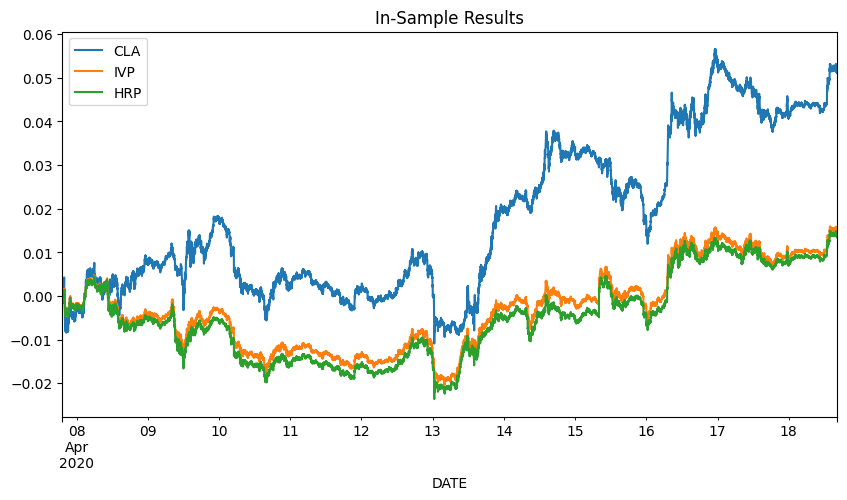

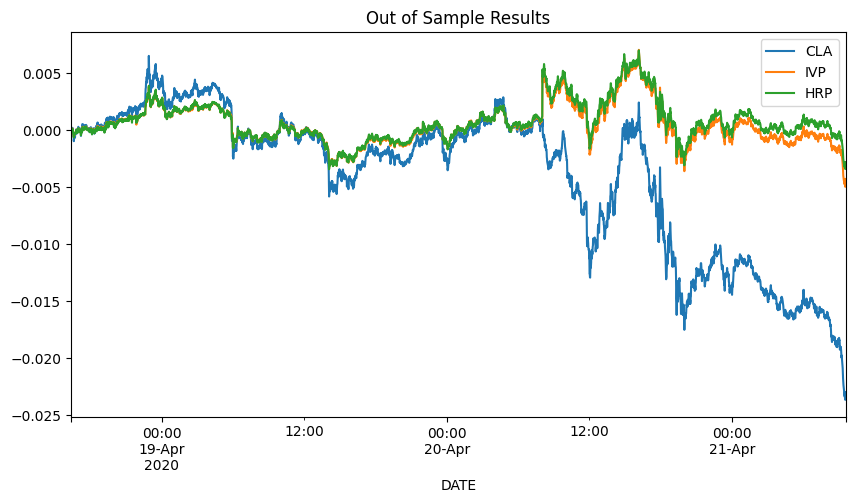

In [21]:
in_sample_result, out_of_sample_result = portfolio_optimizer.get_results(portfolios)
show_result_plot(in_sample_result, "In-Sample Results")
show_result_plot(out_of_sample_result, "Out of Sample Results")

## 6.2 Sharpe ratio and Standard Deviation

#### In Sample

In [22]:
stdev_and_sharpe_ratio_in_sample = portfolio_optimizer.get_stdev_and_sharpe_ratio(in_sample_result)
stdev_and_sharpe_ratio_in_sample

,stdev,sharp_ratio
CLA,0.005197,0.157934
IVP,0.003379,0.068915
HRP,0.003479,0.061942


#### Out of Sample

In [23]:
stdev_and_sharpe_ratio_out_of_sample = portfolio_optimizer.get_stdev_and_sharpe_ratio(out_of_sample_result)
stdev_and_sharpe_ratio_out_of_sample

,stdev,sharp_ratio
CLA,0.004448,-0.332939
IVP,0.002922,-0.094973
HRP,0.003014,-0.060500


**Conclusion**

Markowitz’s minimum-variance based portfolio allocation should be generally less diverse and concentrated in a few stocks (even if this is not the case here). In the hierarchical clustering-based allocation, the allocation should be more diverse and distributed across many assets. These portfolios then offer better tail risk management.

Finally, we looked at the backtesting framework, which enables us to compute and analyze the in-sample and out of sample return and sharpe ratio of each hypothetical portfolio. This helps in determining the best performer out of all the portfolio allocation methods. The hierarchical clustering approaches yielded the best out-of-sample results, however is still losing money. This could be explained by the small sample set that was used.
